# Sentiment Analysis: Joe

In this file we look at Joes sentiment score globally, his most frequently use words across all lairs, and his most positive and most negative posts across all lairs

### Imports

In [43]:
import pandas as pd
import re, string, unicodedata
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Read in the data

In [44]:
#Here we take data previously made into a csv file 
df =pd.read_csv('user_ids and their posts.csv')
pd.set_option('display.max_colwidth', -1)

### Functions to clean data

In [45]:
def clean_content(df):
    """
    Cleans up the column by removing incidents of '\r', '\n' and, '\n\n' in a dataframe
    simply pass in a dataframe with 'content column'
    """
    df['content'] = df['content'].apply(lambda x: x.replace('\n',' ')) 
    df['content'] = df['content'].apply(lambda x: x.replace('\r',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('\n\n',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('\r\n',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('34',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('39',' '))

In [46]:
def clean_string(string):
    """
    Removes unsightly html code in a given string
    """
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
#     clean0 = re.compile(r'</code></pre>')
#     out = re.sub(clean0,' ', string)
    clean = re.compile('<.*?>')
    out = re.sub(clean,' ', string)
    clean1 = r'^https?:\/\/.*[\r\n]*'
    out = re.sub(clean1,' ', out)
    clean2 = re.compile(r'[^\w\s]')
    out = re.sub(clean2,' ', out)
    return out

In [47]:
# dictionary of all possible contractions
CONTRACTION_MAP = {
"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
"haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have",
"he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would",
"I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would",
"i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not",
"it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is",
"let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
"she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
"so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would",
"there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
"they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
"wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have",
"what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
"where'd": "where did","where's": "where is","where've": "where have","who'll": "who will",
"who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
"will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
"you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"
}

# function to expand contractions in text
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """
    Expands any contractions within a given string
    """

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

### Cleaning up Joe's comments

In [48]:
# The steps are important in this function because in order to remove punctations represented as
# html code such an apostrophe which looks like  #&39 = "'", we hade to replace the html with a 
# parser which replaced it with the punctuation, then expanded the contractions back out that way
# we didnt lose any of the meaning of the words. 

import html.parser as htmlparser
parser = htmlparser.HTMLParser()

def clean_comments(df):

    df = df.apply(str)
    df = df.apply(parser.unescape)
    df = df.apply(str)
    df = df.apply(expand_contractions)
    df = df.apply(str)
    df = df.apply(clean_string)
    df = pd.DataFrame(df)
    df.columns =['content']
    df = df[df != 'nan']
    df = clean_content(df)
    
    return df

In [49]:
clean_comments(df)

### Running sentiment analysis on Joe's comments

In [50]:
#import natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
from nltk.probability import FreqDist
import string

## import word tokenizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# get lexicon 
nltk.download('vader_lexicon') 
nltk.download('punkt')
nltk.download('stopwords')

#specify dataframe here
nltk_data = df_joe

# tokenize, stem, and remove stop words
nltk_data['token'] = nltk_data['content'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
nltk_data['stop'] = nltk_data['token'].apply(lambda x: [item for item in x if item not in stop_words])
nltk_data['stem'] = nltk_data['stop'].apply(lambda x: [ps.stem(y) for y in x])
stem_nltk_data = nltk_data['stem'].apply(pd.Series).stack()

# calculate word frequency
fdist_nltk_data = FreqDist(stem_nltk_data)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_nltk_data[punc]

# get list of the 'content' (responses) 
nltk_data_list = list(nltk_data['content'].values)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tshaw/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/tshaw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tshaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


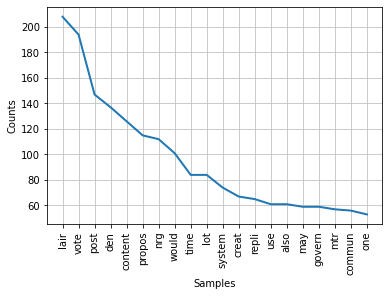

In [51]:
# This is a global analysis of Joes Comments across every lair

# Frequency Distribution Plot - top 20
# run cell twice if freq dist plot doesn't appear
fdist_nltk_data.plot(20, cumulative=False);

In [52]:
# create function that will output dataframe 
# that stores sentiment information
def get_sentiments(input_list):
    """
    output dataframe that stores sentiment information
    """
    output = pd.DataFrame()
    
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)

    return output

In [53]:
# use the get sentiments function on nltk processed joe data
nltk_data_sentiments = get_sentiments(nltk_data_list)
nltk_data_sentiments.head()

,compound,neg,neu,pos,sentence
0,-0.0721,0.371,0.299,0.329,yeah not masks haha
1,-0.4939,0.248,0.641,0.111,right wing selfish and reckless tiger refuses to double mask even to protect other residents of sanctuary cnn
2,0.0000,0.000,1.000,0.000,check this out
3,-0.7003,0.163,0.781,0.056,lemmings rude lemmings some people are just trash and you should be content that you would not do the same to them i think that people that jog with a mask on are stupid myself do not do that these same kids probably wear their mask in the car alone and in bed alone at night hahaha
4,-0.3612,0.333,0.667,0.000,elon musk is science denier reeeeeeeeeeeeeee


In [54]:
# drop token and stop columns for nltk data and create pos, neg, neu, compound columns
nltk_data_sent = nltk_data.drop(['token','stop'],axis=1)\
.assign(pos=nltk_data_sentiments['pos'])\
.assign(neg=nltk_data_sentiments['neg'])\
.assign(neu=nltk_data_sentiments['neu'])\
.assign(compound=nltk_data_sentiments['compound'])

nltk_data_sent.head()

,content,stem,pos,neg,neu,compound
0,yeah not masks haha,"[yeah, mask, haha]",0.329,0.371,0.299,-0.0721
1,right wing selfish and reckless tiger refuses to double mask even to protect other residents of sanctuary cnn,"[right, wing, selfish, reckless, tiger, refus, doubl, mask, even, protect, resid, sanctuari, cnn]",0.111,0.248,0.641,-0.4939
2,check this out,[check],0.000,0.000,1.000,0.0000
3,lemmings rude lemmings some people are just trash and you should be content that you would not do the same to them i think that people that jog with a mask on are stupid myself do not do that these same kids probably wear their mask in the car alone and in bed alone at night hahaha,"[lem, rude, lem, peopl, trash, content, would, think, peopl, jog, mask, stupid, kid, probabl, wear, mask, car, alon, bed, alon, night, hahaha]",0.056,0.163,0.781,-0.7003
4,elon musk is science denier reeeeeeeeeeeeeee,"[elon, musk, scienc, denier, reeeeeeeeeeeeeee]",0.000,0.333,0.667,-0.3612


In [55]:
# check out joes global sentiment score
joe_global_sentiment = nltk_data_sent["compound"].mean()
joe_global_sentiment

0.31640368852459005

In [56]:
# see where the most negative message is located
nltk_data_sent['compound'].argmin()
# look at the most negative column
nltk_data_sent.loc[[136]]

,content,stem,pos,neg,neu,compound
136,if we do not know the winner by monday morning i will claim victory,"[know, winner, monday, morn, claim, victori]",0.108,0.237,0.655,-0.9954


In [57]:
# see where the most postive message
nltk_data_sent['compound'].argmax()
nltk_data_sent.loc[[310]]

,content,stem,pos,neg,neu,compound
310,we should all be grateful that one of our devs did an analysis on a saturday morning good guy amazing dev here are his results the negative nrg completely negated their positive nrg the 0 15 902649 642112 mtr they earned is the total from evaluation mtr use and nrg use so sorry that you had so much negative nrg but that result is expected i will ask the dev if we can improve the estimates in a case like this thankfully it should not happen too often that you get so much negative nrg,"[grate, one, dev, analysi, saturday, morn, good, guy, amaz, dev, result, neg, nrg, complet, negat, posit, nrg, 0, 15, 902649, 642112, mtr, earn, total, evalu, mtr, use, nrg, use, sorri, much, neg, nrg, result, expect, ask, dev, improv, estim, case, like, thank, happen, often, get, much, neg, nrg]",0.0,0.0,1.0,0.0
